# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Loading Data 

In [3]:
# fetch dataset 
waveform_database_generator_version_1 = fetch_ucirepo(id=107) 
statlog_german_credit_data = fetch_ucirepo(id=144)

In [4]:
# extracting features and tragets for both datasets
german_data_X = statlog_german_credit_data.data.features
german_data_Y = statlog_german_credit_data.data.targets

waveform_data_X = waveform_database_generator_version_1.data.features
waveform_data_Y = waveform_database_generator_version_1.data.targets

In [5]:
# waveform dataset
display(waveform_data_X.head())
display(waveform_data_Y.head())
non_numeric_w = waveform_data_X.select_dtypes(include='object').columns
display(non_numeric_w)

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20,Attribute21
0,-1.23,-1.56,-1.75,-0.28,0.60,2.22,0.85,0.21,-0.20,0.89,...,4.20,2.89,7.75,4.59,3.15,5.12,3.32,1.20,0.24,-0.56
1,-0.69,2.43,0.61,2.08,2.30,3.25,5.52,4.55,2.97,2.22,...,1.61,1.24,1.89,1.88,-1.34,0.83,1.41,1.78,0.60,2.42
2,-0.12,-0.94,1.29,2.59,2.42,3.55,4.94,3.25,1.90,2.07,...,1.45,2.50,0.12,1.41,2.78,0.64,0.62,-0.01,-0.79,-0.12
3,0.86,0.29,2.19,-0.02,1.13,2.51,2.37,5.45,5.45,4.84,...,4.05,2.58,1.40,1.24,1.41,1.07,-1.43,2.84,-1.18,1.12
4,1.16,0.37,0.40,-0.59,2.66,1.00,2.69,4.06,5.34,3.53,...,4.79,4.30,1.84,1.73,0.21,-0.18,0.13,-0.21,-0.80,-0.68


,class
0,2
1,1
2,0
3,1
4,1


Index([], dtype='object')

# Part 1: Inference Efficiency (Statlog German Credit Data)

### 1. Preprocessing  

In [6]:
# initial dataset exploration

# german dataset
display(german_data_X.head())
display(german_data_Y.head())
non_numeric_g = german_data_X.select_dtypes(include='object').columns
display(non_numeric_g)

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


,class
0,1
1,2
2,1
3,1
4,2


Index(['Attribute1', 'Attribute3', 'Attribute4', 'Attribute6', 'Attribute7',
       'Attribute9', 'Attribute10', 'Attribute12', 'Attribute14',
       'Attribute15', 'Attribute17', 'Attribute19', 'Attribute20'],
      dtype='object')

We pre-process categorical features for better minkowski-distance compatibility. The following features have a completely arbitrary ordering or contain only 2 unique values:

- attribute 4: Purpose
    - arbitrary purchases on credit

- attribute 9: Personal status and sex
    - no real ordering to marital status and sex

- attribute 19: Telephone
    - yes or no

- attribute 20: foreign worker
    - yes or no

For these features we use **one-hot encoding** and **label encoding**

In [28]:
# first we can one-hot encode attribute 4 and 9
german_data_X_encodings = pd.get_dummies(data=german_data_X, columns=['Attribute4','Attribute9']).apply(lambda x: x.apply(lambda x: int(x) if isinstance(x,bool) else x))
display(german_data_X_encodings.loc[:,'Attribute4_A40':].head())

,Attribute4_A40,Attribute4_A41,Attribute4_A410,Attribute4_A42,Attribute4_A43,Attribute4_A44,Attribute4_A45,Attribute4_A46,Attribute4_A48,Attribute4_A49,Attribute9_A91,Attribute9_A92,Attribute9_A93,Attribute9_A94
0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [31]:
# next we apply label encoding to attributes 19 and 20
label_encoder = LabelEncoder()
german_data_X_encodings[['Attribute19', 'Attribute20']] = german_data_X_encodings[['Attribute19', 'Attribute20']].apply(lambda x: label_encoder.fit_transform(x))
display(german_data_X_encodings[['Attribute19', 'Attribute20']].value_counts().reset_index(name='count'))

,Attribute19,Attribute20,count
0,0,0,564
1,1,0,399
2,0,1,32
3,1,1,5


- **Attribute 1**: Status of existing checking account
  - A11 (< 0 DM) → A12 (0 <= & < 200 DM) → A13 (>= 200 DM / salary assignments for at least 1 year) → A14 (no checking account)
  
- **Attribute 3**: Credit history
  - A34 (critical account / other credits existing) → A33 (delay in paying off in the past) → A32 (existing credits paid back duly till now) → A31 (all credits at this bank paid back duly) → A30 (no credits taken / all credits paid back duly)
  
- **Attribute 6**: Savings account / bonds
  - A61 (< 100 DM) → A62 (100 <= & < 500 DM) → A63 (500 <= & < 1000 DM) → A64 (>= 1000 DM) → A65 (unknown / no savings account)

- **Attribute 7**: Present employment since
  - A71 (unemployed) → A72 (< 1 year) → A73 (1 <= & < 4 years) → A74 (4 <= & < 7 years) → A75 (>= 7 years)

- **Attribute 12**: Property
  - A124 (unknown / no property) → A123 (car or other, not in attribute 6) → A122 (building society savings agreement / life insurance) → A121 (real estate)

- **Attribute 17**: Job
  - A171 (unemployed / unskilled - non-resident) → A172 (unskilled - resident) → A173 (skilled employee / official) → A174 (management / self-employed / highly qualified employee / officer)


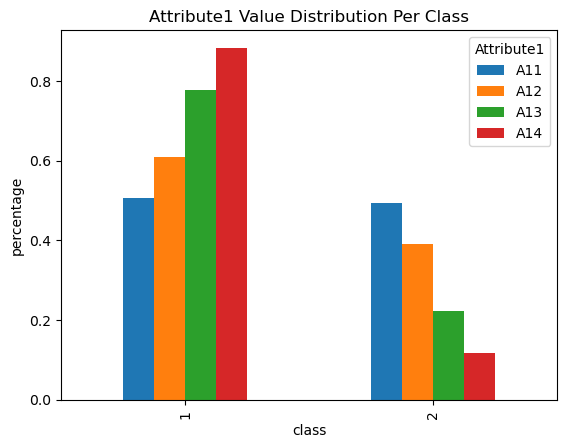

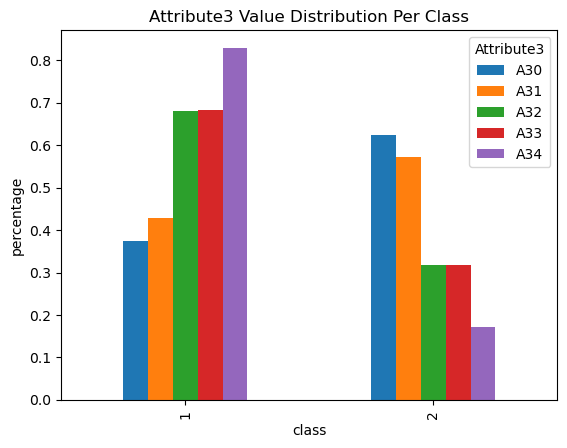

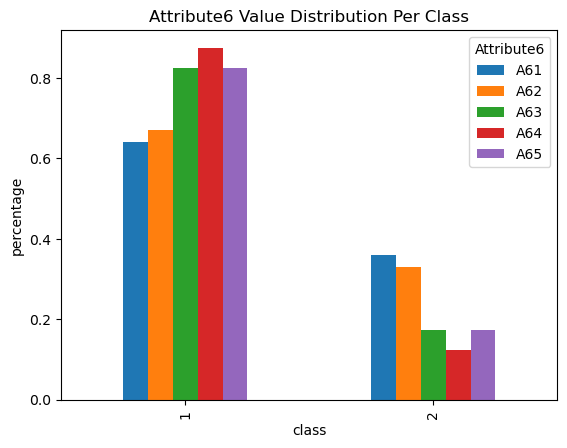

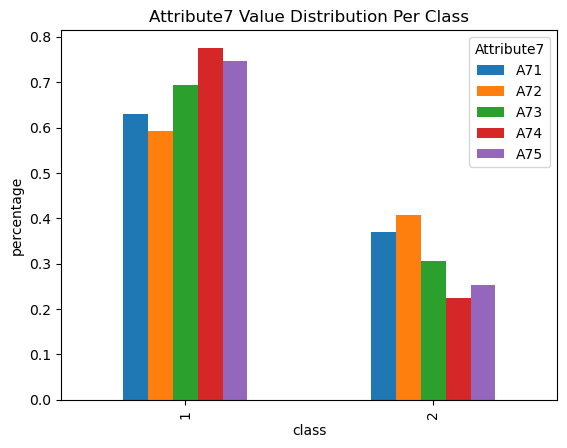

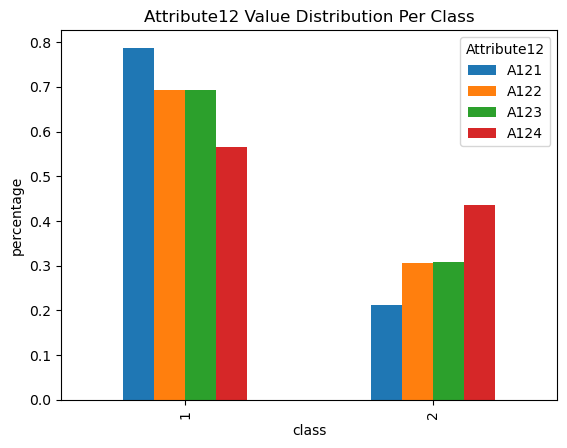

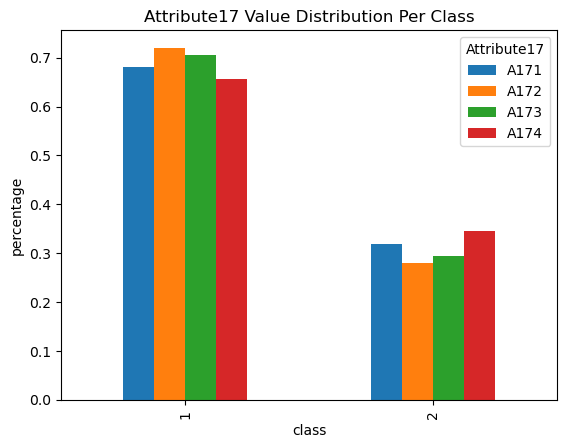

In [33]:
fig, axes = plt.subplots(2,3)


for a in ['Attribute1', 'Attribute3', 'Attribute6', 'Attribute7', 'Attribute12', 'Attribute17']:
    grouped = pd.concat([german_data_X[a],german_data_Y], axis=1).groupby(['class',a]).size()
    attr_counts = german_data_X[a].value_counts()
    creditworthy_values = grouped.reset_index(name='count')
    creditworthy_values['percent_in_class'] = creditworthy_values.apply(lambda x: x['count']/attr_counts[x[a]], axis=1)
    creditworthy_values.pivot(index='class', columns=a, values='percent_in_class').plot(kind='bar', title=f"{a} Value Distribution Per Class", xlabel='class', ylabel="percentage",
                                                                                        legend=True)

<Axes: xlabel='Attribute14'>

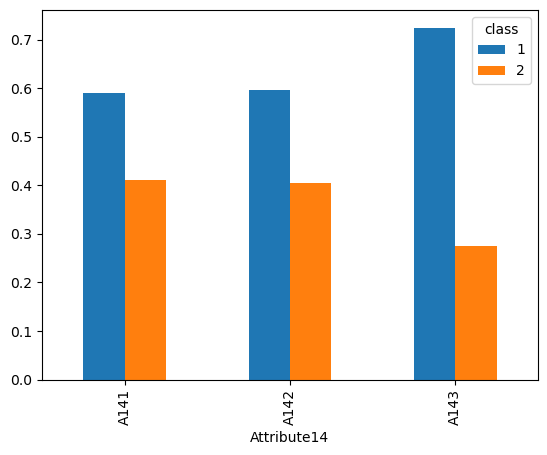

In [23]:
grouped = pd.concat([german_data_X_encodings['Attribute14'], german_data_Y], axis=1).groupby(['Attribute14','class']).size()
attr_counts = german_data_X['Attribute14'].value_counts()
credit_worthiness = grouped.reset_index(name='count')
credit_worthiness['percent_in_class'] = credit_worthiness.apply(lambda x: x['count']/attr_counts[x['Attribute14']], axis=1)
credit_worthiness.pivot(index='Attribute14',columns='class', values='percent_in_class').plot(kind='bar',)

For the following features, there appears to be a clear order from least credit-worthy to most credit-worthy categories which we can visualize using multi-bar plots:

- attribute 1: Status of existing checking account
    - A11() $\to$ A12 $\to$ A13 $\to$ A14

- attribute 3: Credit history
    - A30 $\to$ A31 $\to$ A32 $\to$ A33 $\to$ A34

- attribute 6: Savings accounts
    - A61 $\to$ A62 $\to$ A63 $\to$ A64 $\to$ A65

- attribute 7: Present employment since
    - A71 $\to$ A72 $\to$ A73 $\to$ A74 $\to$ A75

- attribute 7: Present employment since
    - A71 $\to$ A72 $\to$ A73 $\to$ A74 $\to$ A75
